This notebook will cover how to turn OSM data into image masks that you can use to train an NN.  When we get this data, it's formatted as vectors, meaning it contains information about the outlines of objects.  In order to use it to train an NN, we need to create raster images out of it.  We can use OpenCV for this task.

OpenCV has a function called `fillPoly` that fills in polygons, but we can't use it right away because `fillPoly` assumes that all of your polygons are in image coordiantes, but our objects are in geospatial coordinates.  So first, we will have to transform our geospatial data into image coordinates.

To create our training images, we will have to do the following things
1. Find the objects that intersect with the image
2. Make sure the vector data is in the same CRS as the image
3. Use the GeoTiff metadata to transform the geospatial coordinates into image coordinates
4. Use OpenCV to turn the vectors into rasters

In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio

%matplotlib inline


def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image to uint8 values.  This helps to deal with 11-bit imagery.
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

First, let's take stock of the ground truth.  I'm going to load the nature.geojson file that I created in the the OSM downloading script.  This should contain information about natural features in Paris.

In [2]:
osm_nature = gpd.read_file('vectors/nature.geojson')
osm_nature.head()

,geometry,golf,id,landuse,lavoir,name,natural,water
0,"LINESTRING (2.2854469 49.0290783, 2.2857866 49...",None,26319838,None,None,None,fell,None
1,"LINESTRING (2.2825321 49.001852, 2.2825092 49....",None,36513568,None,None,None,water,lake
2,"LINESTRING (2.2476226 49.012904, 2.2468916 49....",None,41303503,None,None,None,wood,None
3,"LINESTRING (2.2374589 49.0324605, 2.2375362 49...",None,41311081,None,None,Étang Godard,water,None
4,"LINESTRING (2.2527052 49.0197614, 2.2540327 49...",None,41317560,None,None,None,wood,None


It looks like the `natural` column tells us what kind of natural feature is in each row, so let's have a look at the values in that column.

In [3]:
from collections import Counter
Counter(osm_nature.natural)

Counter({'fell': 1, 'sand': 18, 'water': 29, 'wood': 10})

It looks like we have 29 "water" features, 10 "wood" features, and 18 "sand features".  We also have one "fell" feature.  I wasn't sure what that was, so I [looked it up](http://wiki.openstreetmap.org/wiki/Tag:natural%3Dfell). I think it might be a misnomer, since I don't think any of Paris is above the tree line.

Anyway, let's try working with the "wood" category.

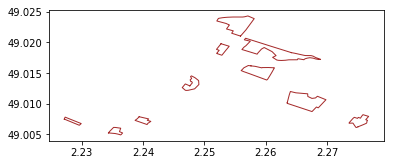

In [4]:
osm_nature[osm_nature.natural == 'wood'].plot(color='brown')

Ok, so we've got a few wooded areas here.

A little aside: it looks like this is a set of linestrings, but we need polygons.  The difference is that a polygon is filled, but a linestring is not.  Let's try fixing that

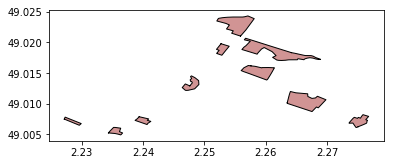

In [5]:
import shapely.geometry
osm_nature.set_geometry(osm_nature.geometry.apply(shapely.geometry.Polygon), inplace=True)
osm_nature[osm_nature.natural == 'wood'].plot(color='brown')

Consider it fixed!

One of the things that makes working with geospatial data so fun is that you often have to look in multiple places to get all of the information.  I recall from the download script that there were other tags that referred to forests.  Let's also have a look at the landuse.geojson file.

In [6]:
osm_landuse = gpd.read_file('vectors/landuse.geojson')
osm_landuse.set_geometry(osm_landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)
osm_landuse.head()

,CLC:code,CLC:id,CLC:year,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,barrier,basin,...,shop,source:name,source:opening_hours,subdivision:FR,tourism,traffic_sign,url,website,wheelchair,wikipedia
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


This one has too many columns to see in the head view.  Let's look directly at the list of columns and try to find the right one to look at.

In [7]:
osm_landuse.columns

Index(['CLC:code', 'CLC:id', 'CLC:year', 'addr:city', 'addr:housenumber',
       'addr:postcode', 'addr:street', 'amenity', 'barrier', 'basin', 'brand',
       'compressed_air', 'crop', 'denomination', 'description', 'ele',
       'fuel:diesel', 'fuel:e10', 'fuel:e85', 'fuel:octane_98', 'geometry',
       'golf', 'highway', 'id', 'junction', 'landuse', 'leaf_type', 'man_made',
       'maxheight', 'maxweight', 'name', 'natural', 'note', 'opening_hours',
       'operator', 'railway', 'ref', 'ref:FR:FANTOIR',
       'ref:FR:prix-carburants', 'religion', 'shop', 'source:name',
       'source:opening_hours', 'subdivision:FR', 'tourism', 'traffic_sign',
       'url', 'website', 'wheelchair', 'wikipedia'],
      dtype='object')

Call it a hunch...

In [8]:
Counter(osm_landuse.landuse)

Counter({'allotments': 4,
         'basin': 6,
         'brownfield': 1,
         'cemetery': 23,
         'commercial': 3,
         'construction': 8,
         'farmland': 12,
         'farmyard': 6,
         'forest': 161,
         'grass': 36,
         'greenhouse_horticulture': 1,
         'industrial': 5,
         'meadow': 3,
         'quarry': 1,
         'recreation_ground': 5,
         'residential': 29,
         'retail': 12,
         'sand': 10,
         'school': 2,
         'subdivision': 1,
         'vineyard': 3})

Ok, now we have 161 more forests. That's significant.

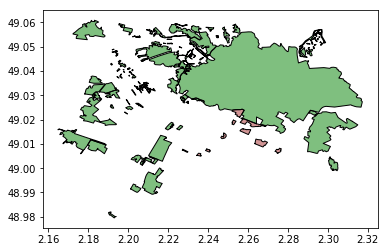

In [9]:
fig, ax = plt.subplots()
osm_landuse[osm_landuse.landuse == 'forest'].plot(color='g', ax=ax)
osm_nature[osm_nature.natural == 'wood'].plot(color='brown', ax=ax)

So we can see that the two sources of data are mostly independent.  There's a little overlap, but not much.  So make sure that whatever kind of data you're using, that you find all the places you need to look.

Now let's see where the spacenet images are.  We'll load the image_summary.geojson file that we made in the exploring OSN notebook and plot it on top of the two sources of forest data.

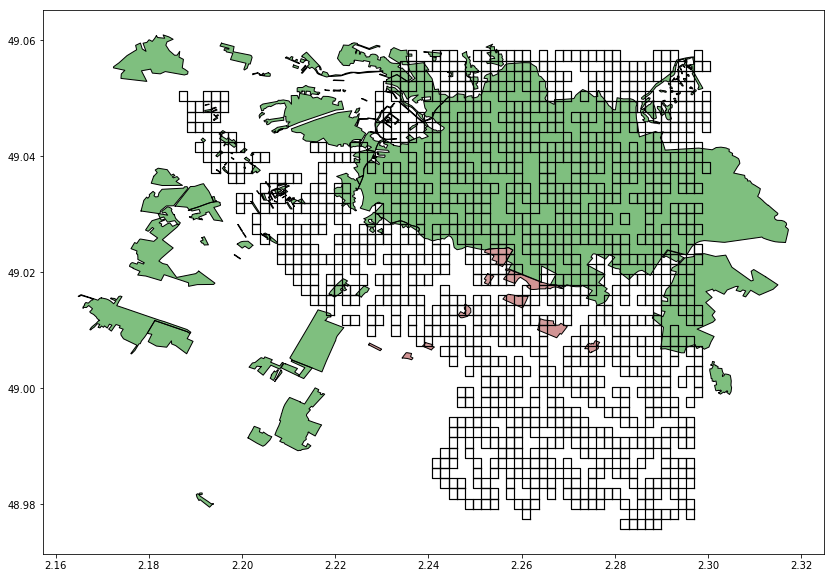

In [10]:
image_summary = gpd.read_file('vectors/image_summary.geojson')
fig, ax = plt.subplots(figsize = (14,10))
osm_landuse[osm_landuse.landuse == 'forest'].buffer(0).plot(color='g', ax=ax)
osm_nature[osm_nature.natural == 'wood'].plot(color='brown', ax=ax)
image_summary.plot(color='w', alpha=0.1, linewidth=1.2, ax=ax)

Low let's find all the images that have forest in them


In [11]:
part1 = osm_landuse[osm_landuse.landuse == 'forest'].unary_union
part2 = osm_nature[osm_nature.natural == 'wood'].unary_union
all_forest = part1.union(part2)

images_containing_forest = image_summary[image_summary.intersects(all_forest)]
images_containing_forest.head()

,geometry,image_name
0,"POLYGON ((2.27416139993 49.0248909, 2.27416139...",/media/alan/storage/data/spacenet/AOI_3_Paris_...
3,"POLYGON ((2.29697639993 49.0073409, 2.29697639...",/media/alan/storage/data/spacenet/AOI_3_Paris_...
4,"POLYGON ((2.29346639993 49.0494609, 2.29346639...",/media/alan/storage/data/spacenet/AOI_3_Paris_...
6,"POLYGON ((2.27065139994 49.0231359, 2.27065139...",/media/alan/storage/data/spacenet/AOI_3_Paris_...
7,"POLYGON ((2.28995639993 49.0319109, 2.28995639...",/media/alan/storage/data/spacenet/AOI_3_Paris_...


In [12]:
file_name = images_containing_forest.image_name.values[0]

with rasterio.open(file_name) as src:
        img = scale_bands(src.read([5, 3, 2]).transpose([1,2,0]))
        img_bounds = shapely.geometry.box(*src.bounds)
        img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
        

Now let's see what part of this image is covered by forest.  It looks like th

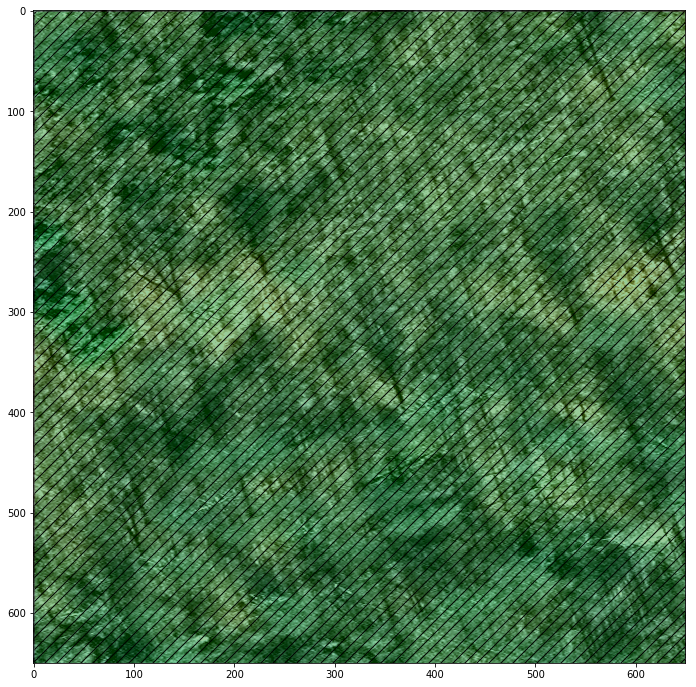

In [13]:
from descartes import PolygonPatch

# Get the intersection between the forest and the image bounds
image_forest_area = all_forest.intersection(img_bounds)

# Transform it into pixel coordinates
image_forest_area_pxcoords = shapely.affinity.affine_transform(image_forest_area, img_transform)

fig, ax = plt.subplots(figsize=(12,12))

# Plot the image
ax.imshow(scale_bands(img))

# Plot the forest on top of the image
ax.add_patch(PolygonPatch(image_forest_area_pxcoords, fc='g', alpha=0.4, hatch='//'))

It looks like the whole image is a forest.

Just to confirm that we're not crazy, let's confirm that this image is inside of a big forest.

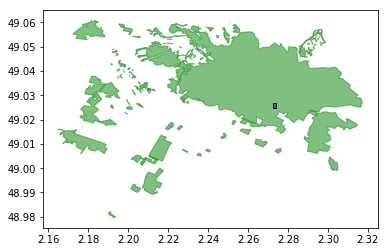

In [14]:
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

# Prepare a collection of PolygonPatches so we can plot it.
patches = [PolygonPatch(poly,fc='g', ec='g', alpha=0.5)
           for poly in all_forest]

# Create a figure
fig, ax = plt.subplots()

# Show all of the forest areas
ax.add_collection(PatchCollection(patches, match_original=True))

# Show the image box
ax.add_patch(PolygonPatch(img_bounds))

# Rescale the axes
ax.autoscale_view()

Cool.

Now let's generate that mask, but first lets fine an image that's not 100% forest to make things more intersting.

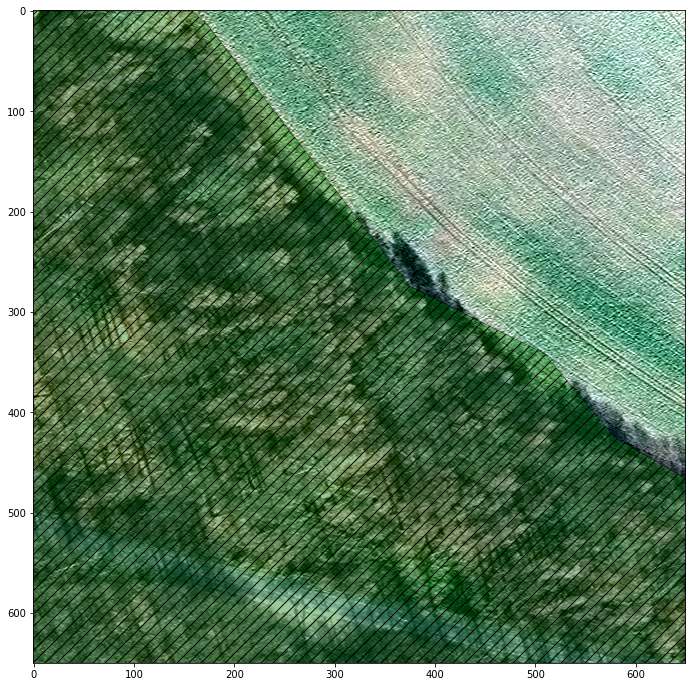

In [15]:
# Calculate the proportion of each image taken up by forest
proportion_forest = images_containing_forest.intersection(all_forest).area / images_containing_forest.area

# Find the images with between 20% and 80% forest
has_some_forest = np.logical_and(0.2 < proportion_forest, proportion_forest < 0.8)
images_containing_some_forest = images_containing_forest[has_some_forest]

# Pick the first image on the list
file_name = images_containing_some_forest.image_name.values[0]

# Load the image
with rasterio.open(file_name) as src:
        img = scale_bands(src.read([5, 3, 2]).transpose([1,2,0]))
        img_bounds = shapely.geometry.box(*src.bounds)
        img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
        
# Get the intersection between the forest and the image bounds
image_forest_area = all_forest.intersection(img_bounds)

# Transform it into pixel coordinates
image_forest_area_pxcoords = shapely.affinity.affine_transform(image_forest_area, img_transform)

fig, ax = plt.subplots(figsize=(12,12))

# Plot the image
ax.imshow(scale_bands(img))

# Plot the forest on top of the image
ax.add_patch(PolygonPatch(image_forest_area_pxcoords, fc='g', alpha=0.4, hatch='//'))

Ok, great.  Now let's finally make that mask.  We're going to use opencv to fill in the polygon.

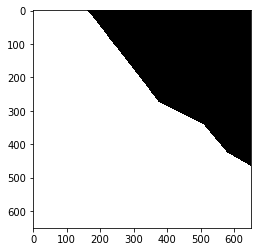

In [16]:
import cv2

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

# Convert the forest polygon into a mask
forest_mask = make_mask(img.shape, image_forest_area_pxcoords)

# Plot it
plt.imshow(forest_mask, cmap=plt.cm.gray)